# Data Science Programming Assignment - Tim Durand

In [1]:
## Import Packages
# Data
import numpy as np
from numpy import nansum
import pandas as pd
import datetime

# Visualisation
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8.0, 5.0]
import seaborn as sns
sns.set(font_scale=1)
# Set the styling for dataframes
dfstyles = [dict(selector="caption", props=[("font-size", "120%"),("color", "black"),("text-align", "center")])]
from IPython.display import display,HTML

# Dates
from datetime import datetime

# Data Import Functions
import DSPImport

# Data Cleansing Functions
import DSPCleanse

# Data Exploration Functions
import DSPAnalyse

# Modelling
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [4]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<b>NOTE</b>: DSPCleanse, DSPAnalyse and DSPImport are supplementary modules, and should reside in the same directory as this notebook
<br>
The code for this notebook is, by default, hidden. To display the code cells, click <a href="javascript:code_toggle()">here</a>.\r\n''')

## Executive Summary
The objective of this report is to explore a dataset of high-power electrical transformers. Analysis, is focussed on two distinct failure modes; Early life failure and Wear-and-tear failure. 

Python was used exclusively for this task. A variety of libraries were used for processing, joining and transforming data, as well as examination, modelling and visualisation. The most challenging aspect, was cleansing some of the chaotic source data, particularly dates.

For Early life failures; the most important feature in the data was device Install date; this failure mode was much more frequent in recent years, which may indicate quality issues for newer devices. In relation to the failure date; warmer months had an increased frequency of failures, perhaps suggesting an issue with the weather or increased demand. With regards Wear-and-tear failures; Manufacturers 24 and 2, were more likely to fail as well as devices with a Power rating of 7, 10 and 30 MVA. MQ was the worst region for this type of failure; perhaps inferring engineer resource issues.

## Problem Definition
A South American utility company has a fleet of high-power electrical transformers, the task is to investigate and provide conclusions on two failure modes: 

* Early life failures, occur within three years of installation. 
* Wear-and-tear failures, are usually the result of normal wear-and-tear, and occur after at least three years of operation.

## Preliminary Data Exploration

### Consolidation

The first task was to import and consolidate the data; the importcombine function was declared in the DSPImport library for this task and called from this notebook.
The steps for this process include:
* Combine all files in a given directory
* List the files in the directory
* For each file, read each one into memory, skipping the title cell at the top.

The end result is a single dataframe for Events and a seperate dataframe for Devices.

In [5]:
# Import the event data and combine into one data frame
eventdatadir = 'C:/Users/durandt/Documents/Aston/Data Sets/CWdata/Events/'
eventdf = DSPImport.importcombine(eventdatadir)

In [6]:
# Import the event data and combine into one data frame
devicedatadir = 'C:/Users/durandt/Documents/Aston/Data Sets/CWdata/Devices/'
devicedf = DSPImport.importcombine(devicedatadir)

### Events Exploration

Columns were first cleansed to aid data exploration; spaces were replaced with an underscore using the replace() function, and the title() function was used to format the column names to title case. The function is called cleansecolumns, and can be found in the DSPCleanse library.

In [7]:
eventdf = DSPCleanse.cleansecolumns(eventdf)

In order to streamline the analysis process, a function was declared in the DSPAnalyse library to gather a number of metrics from the data, it can be found named dataprofile. The function contains the following steps:
* Initalise an empty list for each metric.
* For each column in the passed dataframe gather metrics on the data, including the length of data contained in the column and the number of missing values.
* Append the metrics to an individual metric list.
* Return a dataframe.


In [8]:
display(DSPAnalyse.dataprofile(eventdf).style.set_table_styles(dfstyles).set_caption('Events Table - Data Profile'))

,Column,Data Type,Max Length,Max Length Value,Min Length,Min Length Value,Null #,Null %,Row Count,Unique Values
0,Area_Code,object,2,CE,2,CE,0,0,27309,7
1,Op_Id,int64,9,200080202,9,200080202,0,0,27309,27309
2,Op_Date,object,10,15/12/2012,10,15/12/2012,0,0,27309,2951
3,Equipment_Id,object,32,990e12bfb94106af12de1290f54dec92,32,990e12bfb94106af12de1290f54dec92,0,0,27309,3941
4,Fail_Flag,object,3,nan,1,X,26351,96.49,27309,1


The Op ID column serves as a primary key for an event, no cleaning of this column was required as it does not contain any NULL or duplicate values and all values are of a consistant integer data type.  

The Fail_Flag is a boolean variable, indicating whether an event was a distructive failure. A NULL value represents False. One can see from the above table, that the only unique value is "X", representing a True value. The NULL and "X" values require transformation to True/False. 

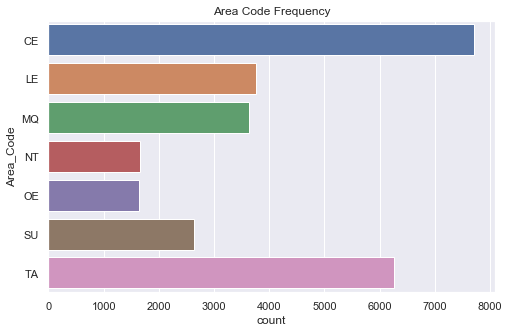

In [9]:
# Plot the count of rows per Area Code
ax = sns.countplot(y="Area_Code", data=eventdf).set_title('Area Code Frequency')
plt.show()

The above chart shows the distribution of events by area; one can conclude that the CE and TA areas have the most events reported, more than 3 times the number of events reported for NT and OE. One cannot yet conclude that environmental factors are contributing to more frequent events in these areas; it may simply be the case that these areas have more devices. The data is in a consistant, two letter string format and there are no missing values; therefore no data cleansing is required.

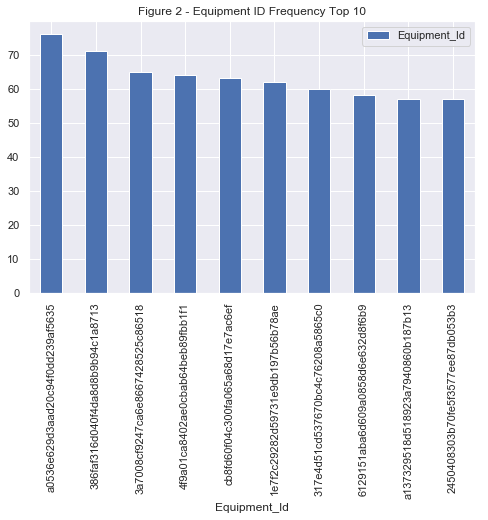

In [10]:
# Plot the count of rows per Equipment Item
eventdf.groupby('Equipment_Id').agg({'Equipment_Id':'count'}).sort_values('Equipment_Id',ascending = False)\
.head(10).plot(kind='bar', title='Figure 2 - Equipment ID Frequency Top 10')
plt.show()

The Equipment ID column serves as a primary key for the device, it does not contain any missing values. Duplicate values are present, and expected, because each piece of equipment can have multiple events before a distructive failure. The device with the highest event count has over 70 events.

In [11]:
# Top 10 Op_Date
display(eventdf['Op_Date'].head(10).to_frame().style.set_table_styles(dfstyles).set_caption('Top 10 Op Date'))

,Op_Date
0,15/12/2012
1,18/11/1999
2,05/04/2000
3,14/04/2000
4,08/07/2000
5,11/07/2000
6,13/07/2000
7,18/07/2000
8,08/08/2000
9,08/08/2000


Examining the top 10 date values above, the date format is **%d/%m/%Y** where:  
**%d** = Day of the month as a zero-padded decimal number.  
**%m** = Month as a zero-padded decimal number.  
**%Y** = Year with century as a decimal number.

To ensure every date falls into the format: %d/%m/%Y, a function was formed using strptime. This function was then passed each date to test against the format; any unparsable dates were added to a list for further examination. The function can be found in the DSPCleanse library named testdates.

In [12]:
# Pass the Op_Date column to the testdates function along with the assumed format
dformat = '%d/%m/%Y'
unparsabledates = list(eventdf['Op_Date'].apply(DSPCleanse.testdates,inputformat=dformat))
print("Count of Unparsable Dates: " + str(unparsabledates.count(True)))

Count of Unparsable Dates: 0


The list of unparsable dates is empty, meaning all dates are consistant with the expected format, and the column can easily be converted to datetime64 format using strftime.

In [13]:
# show unique values in the day field of the date
day = eventdf.Op_Date.str[:2].astype(int).unique()
print("Unique Values in the first two characters of Op_Date:")
display(np.sort(day))

Unique Values in the first two characters of Op_Date:


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], dtype=int64)

To confirm the first two characters are the day part of a date, and not the month; a substring of the first two characters was taken, and the unique values examined.
The above array confirms the first two characters are integers ranging between 1 and 31; inferring the day element of the date. If the array contained integers ranging between 1 and 12, it could have suggested this date part contained the month element.

### Devices Exploration

Column names were once again cleansed prior to exploration with the cleansecolumns function; spaces were replaced with an underscore and parenthesis with an empty string.

In [14]:
devicedf = DSPCleanse.cleansecolumns(devicedf)
display(DSPAnalyse.dataprofile(devicedf).style.set_table_styles(dfstyles).set_caption('Devices Table - Data Profile'))

,Column,Data Type,Max Length,Max Length Value,Min Length,Min Length Value,Null #,Null %,Row Count,Unique Values
0,Id,object,32,e230c8f5b9c635e054be4463878b1f37,32,e230c8f5b9c635e054be4463878b1f37,0,0,651,651
1,Type,object,38,Transformer (Mobile SS remote control),17,Power Transformer,0,0,651,4
2,Area,object,2,NT,2,NT,0,0,651,7
3,Function,object,17,DEDICATED RESERVE,2,T3,0,0,651,25
4,Manufacturer,object,19,MANUFACTURER-UNKNWN,3,nan,3,0.46,651,28
5,Install_Date,object,10,15.06.2012,3,nan,97,14.9,651,427
6,Phases,object,6,SINGLE,3,nan,22,3.38,651,2
7,Power_Mva,object,8,"5.000,00",3,nan,18,2.76,651,30
8,Voltage_Regulation,object,3,nan,2,NO,28,4.3,651,2
9,Nominal_Voltage_Kv,object,6,"145,00",3,nan,20,3.07,651,10


The Id column serves as a primary key for a device; cleansing of this column was not required as it does not contain any missing or duplicate values.

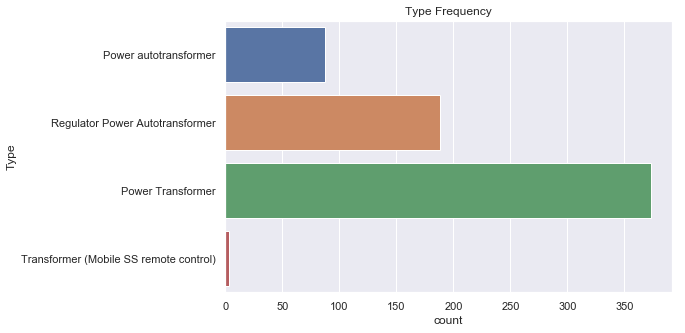

In [15]:
# Plot the count of rows per Type Item
ax = sns.countplot(y="Type", data=devicedf).set_title('Type Frequency')
plt.show()

The Type column represents four different types of devices. One can see from the above, that the Power Transformer category of device is the most prevalent and the Transformer (Mobile SS remote control) represents only a small number of devices. The case and formatting of the strings is inconsistant and could benefit from some cosmetic cleansing.	

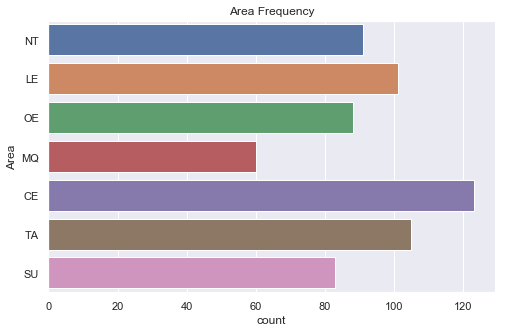

In [16]:
ax = sns.countplot(y="Area", data=devicedf).set_title('Area Frequency')
plt.show()

One can see from the above plot that the CE and TA areas have the highest frequency of devices; this matches the areas with the highest frequency of events. In contrast, OE has a fair amount of devices but the frequency of events is very low.

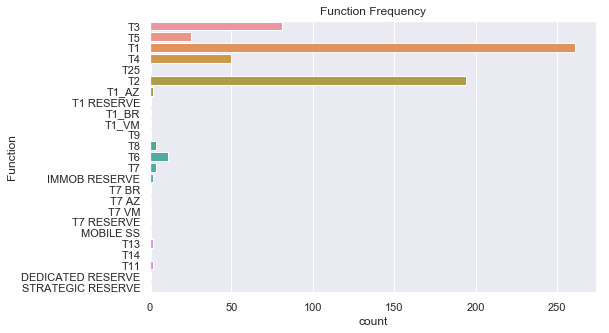

In [17]:
ax = sns.countplot(y="Function", data=devicedf).set_title('Function Frequency')
plt.show()

One can see from the above that there is ailiasing of the categorical Function variable. The variables names T1 to 13 make up the bulk of the devices, T1 and T7 appear multiple times in different forms; perhaps these are subtypes or incorrect data capture. The cleaning strategy will be to remove the characters following "T{digit}". Some values contain the word "reserve"; which may mean that these devices are not running constantly, and may have less wear-and-tear than a primary device. One should group these devies together. MOBILE SS will be kept as it is, because it does not appear to fall into any other category.

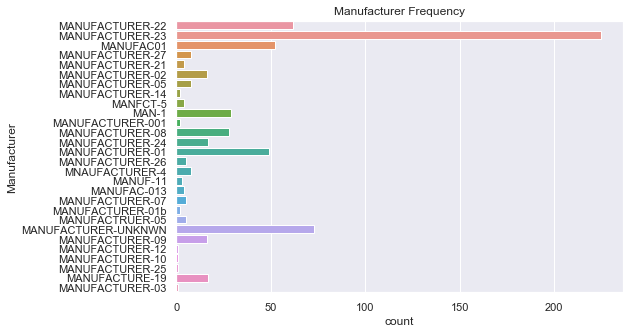

In [18]:
ax = sns.countplot(y="Manufacturer", data=devicedf).set_title('Manufacturer Frequency')
plt.show()

The Manufacturer observation has a small number of missing values, as well as a variable with a name suggesting the manufacturer is unknown. Manufacturer 23 has the largest share of devices in the table, however manufacturer names are expressed inconsistently, for example MANUFAC01, MANUFACTURER-01 and MAN-1 all refer to the same manufacturer. A lookup table should be used to transform these values to the same consistant format, before one is able to make any recomendations on whether the manufacturer affects device failure.

In [19]:
display(devicedf['Install_Date'].tail(10).to_frame().style.set_table_styles(dfstyles).set_caption('Bottom 10 Install Date'))

,Install_Date
641,nan
642,nan
643,23/02/2013
644,02.02.2011
645,02.02.2011
646,14.01.2011
647,15/03/2013
648,05/04/2013
649,01.02.2012
650,nan


One can see from the above sample of Install Date, that it will require some cleansing. In order take corrective action, the different date formats required identification programatically, rather than manually.
Using regular expressions, a function was defined to replace any letter (a-z upper and lower case) with "a", and any single digit with "d"; all other characters are left unchanged. To categorise the pattern of each date, the apply function was used to pass the date values to the dateprofile function. The function resides in the DSPAnalyse library, when called the results are returned to the data frame as a format column. 

In [20]:
# Apply the dateprofile function to the INSTALL_DATE column
devicedf['Install_Date_Format'] = devicedf['Install_Date'].astype(str).fillna("").apply(DSPAnalyse.dateprofile)
# Count the distinct date formats
dateformatdf = devicedf.groupby('Install_Date_Format').agg({'Install_Date_Format':'count'}).\
sort_values('Install_Date_Format',ascending = False)
display(dateformatdf.style.set_table_styles(dfstyles).set_caption('Install Date - Count of each format'))

,Install_Date_Format
Install_Date_Format,
dd.dd.dddd,498
aaa,97
dd/dd/dddd,25
dd-dd-dddd,14
dd.dd.dd,6
da.da.dddd,3
d.dddd,2
a/a,1
dd.dddd,1


The Install Date observation required a significant amount of cleansing; there are almost 15% Null values. The above table of unique patterns shows a number of inconsistant date formats. To decide the best course of corrective action one should examine each pattern in more detail, to decide the best course of action. 

In [21]:
# format1 dd.dd.dddd
for1elem1 = np.max(devicedf['Install_Date'][devicedf['Install_Date_Format'] == 'dd.dd.dddd'].str[:2].astype(int).unique())
for1elem2 = np.max(devicedf['Install_Date'][devicedf['Install_Date_Format'] == 'dd.dd.dddd'].str[3:5].astype(int).unique())
for1elem3 = np.max(devicedf['Install_Date'][devicedf['Install_Date_Format'] == 'dd.dd.dddd'].str[6:10].astype(int).unique())
# format3 dd/dd/dddd
for3elem1 = np.max(devicedf['Install_Date'][devicedf['Install_Date_Format'] == 'dd/dd/dddd'].str[:2].astype(int).unique())
for3elem2 = np.max(devicedf['Install_Date'][devicedf['Install_Date_Format'] == 'dd/dd/dddd'].str[3:5].astype(int).unique())
for3elem3 = np.max(devicedf['Install_Date'][devicedf['Install_Date_Format'] == 'dd/dd/dddd'].str[6:10].astype(int).unique())
maxvaldf = pd.DataFrame({'Format':['dd.dd.dddd','dd/dd/dddd'],'Element1 Max Value':[for1elem1,for3elem1],\
         'Element2 Max Value':[for1elem2,for3elem2], 'Element3 Max Value':[for1elem3,for3elem3]})

# Print the max values of each digit element for the most common 2 data types
display(maxvaldf.style.set_table_styles(dfstyles).set_caption('Identify the date elements of the two most common formats'))

,Element1 Max Value,Element2 Max Value,Element3 Max Value,Format
0,31,12,9999,dd.dd.dddd
1,30,12,2013,dd/dd/dddd


The two most common formats were examined, to confirm the information stored within each date element. Each date was split into its logical parts and the maximum value in each date part returned. One can see from the above analysis, that the dates are in the formats **%d.%m.%Y** and **%d/%m/%Y** respectively. There are some dates in the year 9999 that will need to be imputed or removed.

In [22]:
# Because there is only a small amount of values in the other formats print the whole list
othersdf = devicedf[['Install_Date','Install_Date_Format']][(devicedf['Install_Date_Format'] != 'dd.dd.dddd') & \
           (devicedf['Install_Date_Format'] != 'dd/dd/dddd')].sort_values('Install_Date_Format').drop_duplicates()
display(othersdf.style.set_table_styles(dfstyles).set_caption('List of unique values for the other formats'))

,Install_Date,Install_Date_Format
227,N/D,a/a
9,nan,aaa
504,6.1995,d.dddd
164,7.1999,d.dddd
627,0X.0X.2012,da.da.dddd
324,27-11-1997,dd-dd-dddd
528,19-04-1998,dd-dd-dddd
527,24-05-1998,dd-dd-dddd
325,22-05-1988,dd-dd-dddd
169,15-09-2010,dd-dd-dddd


As there were only a small amount of values in other formats; it made sense to print the whole list of values and examine them individually

In [23]:
# List of values where the year is in the future
format1element3vals = devicedf['Install_Date'][devicedf['Install_Date_Format'] == 'dd.dd.dddd'].str[6:10].astype(int)
print("Values where the year is in the future: ", np.sort(format1element3vals[format1element3vals > 2019])) 

Values where the year is in the future:  [9999 9999]


After analysis of the above information, the author decided the following date formats would be used for conversion, with a focus on converting and keeping as many values as possible: 

| Install Date format | Conversion | Notes         |
|---------------------|------------|---------------|
| dd.dd.dddd          | %d.%m.%Y   | Set the dates in the future to 01/01/1900 as the value cannot be assertained|
| aaa                 | 01/01/1900 | Set the dates in the future to 01/01/1900 as the value cannot be assertained|
| dd/dd/dddd          | %d/%m/%Y   | Day and month within appropriate ranges|
| dd-dd-dddd          | %d-%m-%Y   | Day and month within appropriate ranges|
| dd.dd.dd            | %d.%m.%y   | Day and month within appropriate ranges, Two digit year needs padding|
| da.da.dddd          | 1.1.%Y     | Unable to determine day and month, set to 1st January|
| d.dddd              | 1.%m.%Y    | Unable to determine day, set to 1st of the month|
| a/a                 | 01/01/1900 | Set the dates in the future to 01/01/1900 as the value cannot be assertained|
| dd.dddd             | 1.%m.%Y    | Unable to determine day, set to 1st of the month|
| dd/dd/dd            | %d/%m/%y   | Day and month within appropriate ranges, two digit year needs padding|
| dd/dddd             | 1/%m/%Y    | Unable to determine day, set to 1st of the month|
| ddddd               | excel      | Excel date format, convert to number of days since 1899-12-30|
| dddddddd            | %d%m%Y     | No delimiter, Day and month within appropriate ranges |

Once the Devices and Events are joined together, missing dates (set to 01/01/1900) could be imputed from Events.

In [24]:
# Count the distinct phases
display(devicedf.groupby('Phases').agg({'Phases':'count'}).sort_values('Phases',ascending = False).\
        style.set_table_styles(dfstyles).set_caption('Count of Phase Categories'))
print("NULL Values:" ,devicedf['Phases'].isnull().sum())

,Phases
Phases,
THREE,621
SINGLE,8


NULL Values: 22


One can see from the above that Three phase devices make up the vast majority of values; therefore it would be reasonable to fill the NULL values with "THREE". Machine learning does not work well with missing values.

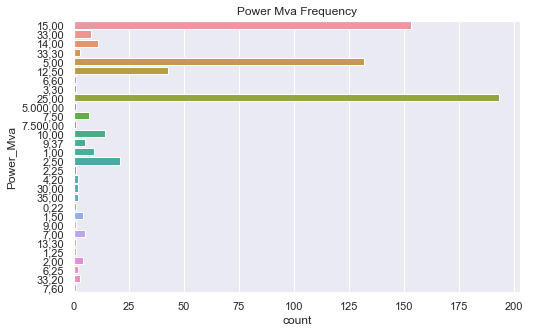

In [25]:
ax = sns.countplot(y="Power_Mva", data=devicedf).set_title('Power Mva Frequency')
plt.show()

Upon inspection of the above plot, and the fact that this data is from South America; it appears that the Spanish decimal and thousands seperator format is in use. A comma should be replaced with a point, and points removed. Values 7500 and 5000 have been reported in the wrong unit of measure, as they are a factor of one thousand higher than the other values. Three Power ratings are dominant and make up the vast majority of devices. Missing values should be replaced with the mean for the variable.

In [26]:
display(devicedf.groupby('Voltage_Regulation').agg({'Voltage_Regulation':'count'}).sort_values('Voltage_Regulation',ascending = False).\
        style.set_table_styles(dfstyles).set_caption('Count of Voltage Regulation Categories'))
print("NULL Values:" ,devicedf['Voltage_Regulation'].isnull().sum())

,Voltage_Regulation
Voltage_Regulation,
NO,323
YES,300


NULL Values: 28


The Voltage Regulation column is a boolean indicator to whether a device has voltage regulation. The 28 missing values will be replaced with the most common value: "NO". YES/NO values should then be converted to 1 and 0 respectively, indicating True and False.

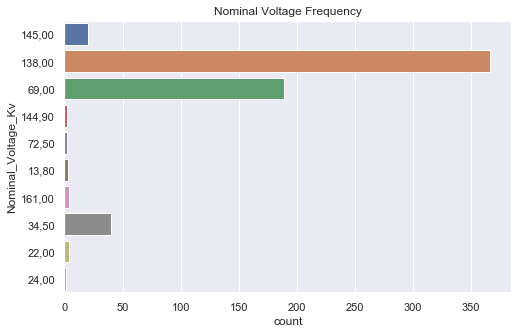

In [27]:
ax = sns.countplot(y="Nominal_Voltage_Kv", data=devicedf).set_title('Nominal Voltage Frequency')
plt.show()

The Nominal Voltage column follows the same format as Power; again a comma should be replaced with a point. The value 138.00 makes up the majority of devices followed by 69.00. missing values should be replaced with the mean value.

## Data Processing

### Cleanse Devices

#### Cleanse Op_Date
A function was written to accept a date value and input format, then parse the value using strptime, with the format as an argument. The output format is **%Y-%m-%d %H:%M:%S**.
The initial exploration of the data confirmed the format is **%d/%m/%Y**. All dates in the Op_Date column conform to this format; so this variable was explicitly set.
The function, found within the DSPCleanse library named convertdates, was passed the date value and format for each row using the apply function, the results are returned to the dataframe and the Op_Date column replaced with the new value.

In [28]:
## Cleanse Op_Date
# Set the expected input format for converting Op_Date
eventdf['Op_Date_New_Format'] = '%d/%m/%Y'
# Apply the convertdates function to the Op_date column
eventdf['Op_Date']= eventdf[['Op_Date', 'Op_Date_New_Format']].apply(DSPCleanse.convertdates, axis=1)
# Convert the Op_Date column to datetime64
eventdf['Op_Date'] = eventdf['Op_Date'].astype('datetime64[ns]')

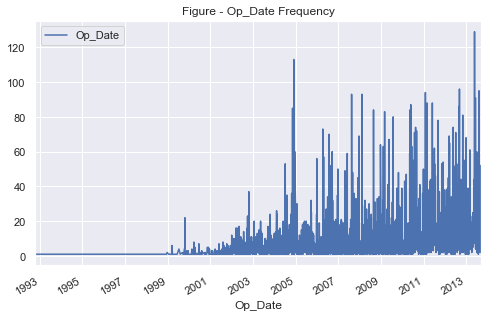

In [29]:
eventdf.groupby('Op_Date').agg({'Op_Date':'count'}).plot(kind='line', title='Figure - Op_Date Frequency')
plt.show()

One can see from the above plot that all dates are now in the correct format.

#### Cleanse Fail_Flag
The following steps were carried out to cleanse the Fail Flag column:
* Use the fillna function to replace missing values with 0, as the absence of an X infers False.
* Use the replace function to replace X with 1 (True).
* Convert the column to the boolean datatype.

The below plot shows the new values.

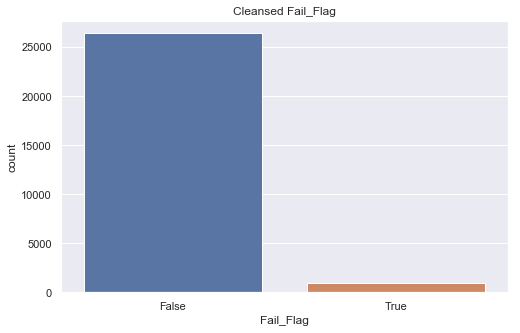

NULL Values: 0


In [30]:
## Cleanse Fail_Flag
# Replace NULLs with 0 
eventdf['Fail_Flag'].fillna(0, inplace=True)
# Replace X with 1
eventdf['Fail_Flag'] = eventdf['Fail_Flag'].replace("X","1")
# Convert to boolean
eventdf['Fail_Flag'] = eventdf['Fail_Flag'].astype(bool)
# Check Values
ax = sns.countplot(x="Fail_Flag", data=eventdf).set_title('Cleansed Fail_Flag')
plt.show()
print("NULL Values:" ,eventdf['Fail_Flag'].isnull().sum())

The Op_Date_New_Format column was used for cleansing only so it was dropped. The processed data was again run through the data profile function to confirm that the data types have changed and there are no missing values. Results below show that the Events table has been sucessfully cleansed.

In [31]:
# Drop the columns used for cleansing only
eventdf = eventdf.drop(['Op_Date_New_Format'], axis=1)
display(DSPAnalyse.dataprofile(eventdf).style.set_table_styles(dfstyles).set_caption('Processed Events Table - Data Profile'))

,Column,Data Type,Max Length,Max Length Value,Min Length,Min Length Value,Null #,Null %,Row Count,Unique Values
0,Area_Code,object,2,CE,2,CE,0,0,27309,7
1,Op_Id,int64,9,200080202,9,200080202,0,0,27309,27309
2,Op_Date,datetime64[ns],10,2012-12-15 00:00:00,10,2012-12-15 00:00:00,0,0,27309,2951
3,Equipment_Id,object,32,990e12bfb94106af12de1290f54dec92,32,990e12bfb94106af12de1290f54dec92,0,0,27309,3941
4,Fail_Flag,bool,5,False,4,True,0,0,27309,2


### Devices Cleansing

#### Cleanse Function
In order to cleanse the function column, a dictionary was created to map the existing categories to new values as below.
The dictionary was then passed as an arguement to the replace function on the column.

| Old Value         | New Value |
|-------------------|-----------|
| T1_AZ             | T1        |
| T1 RESERVE        | RESERVE   |
| T1_BR             | T1        |
| T1_VM             | T1        |
| IMMOB RESERVE     | RESERVE   |
| T7 BR             | T7        |
| T7 AZ             | T7        |
| T7 VM             | T7        |
| T7 RESERVE        | RESERVE   |
| DEDICATED RESERVE | RESERVE   |
| STRATEGIC RESERVE | RESERVE   |
| STRATEGIC RESERVE | RESERVE   |


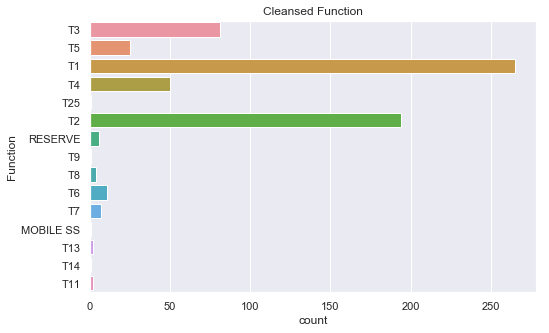

In [32]:
# Create a dictionary to map the values in the function column
Functiondict = {"T1_AZ":"T1","T1 RESERVE":"RESERVE","T1_BR":"T1","T1_VM":"T1","IMMOB RESERVE":"RESERVE",\
                "T7 BR":"T7","T7 AZ":"T7","T7 VM":"T7", "T7 RESERVE":"RESERVE","DEDICATED RESERVE":"RESERVE",\
                "STRATEGIC RESERVE" : "RESERVE"}
# Replace the required values based on the dictionary
devicedf['Function'] = devicedf['Function'].astype(str).replace(Functiondict)
# check unique values
ax = sns.countplot(y="Function", data=devicedf).set_title('Cleansed Function')
plt.show()

The above plot of the function column frequency shows that the new categories are as expected

#### Cleanse Manufacturer
A dictionary of old vs new values was created to map the existing manufacturers to new values. The dictionary was then passed as an arguement to the replace function on the column.

| Old Value           | New Value   |
|---------------------|-------------|
| MANUFACTURER-22     | MAN-22      |
| MANUFACTURER-23     | MAN-23      |
| MANUFAC01           | MAN-01      |
| MANUFACTURER-27     | MAN-27      |
| MANUFACTURER-21     | MAN-21      |
| MANUFACTURER-02     | MAN-02      |
| MANUFACTURER-05     | MAN-05      |
| MANUFACTURER-14     | MAN-14      |
| MANFCT-5            | MAN-05      |
| MAN-1               | MAN-01      |
| MANUFACTURER-001    | MAN-01      |
| MANUFACTURER-08     | MAN-08      |
| MANUFACTURER-24     | MAN-24      |
| MANUFACTURER-01     | MAN-01      |
| nan                 | MAN-UNKNOWN |
| MANUFACTURER-26     | MAN-26      |
| MNAUFACTURER-4      | MAN-04      |
| MANUF-11            | MAN-11      |
| MANUFAC-013         | MAN-13      |
| MANUFACTURER-07     | MAN-07      |
| MANUFACTURER-01b    | MAN-01      |
| MANUFACTRUER-05     | MAN-05      |
| MANUFACTURER-UNKNWN | MAN-UNKNOWN |
| MANUFACTURER-09     | MAN-09      |
| MANUFACTURER-12     | MAN-12      |
| MANUFACTURER-10     | MAN-10      |
| MANUFACTURER-25     | MAN-25      |
| MANUFACTURE-19      | MAN-19      |
| MANUFACTURER-03     | MAN-03      |


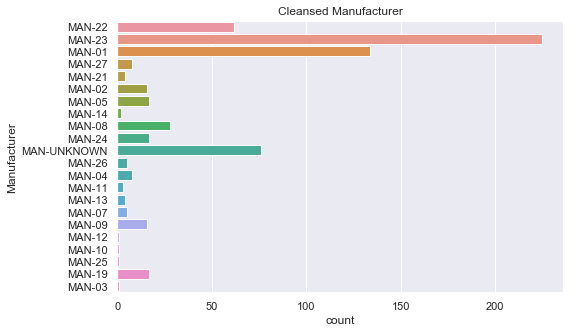

In [33]:
# Create a dictionary to map the values in the Manufacturer column
Mandict = {"MANUFACTURER-22":"MAN-22","MANUFACTURER-23":"MAN-23","MANUFAC01":"MAN-01","MANUFACTURER-27":"MAN-27",\
           "MANUFACTURER-21":"MAN-21","MANUFACTURER-02":"MAN-02","MANUFACTURER-05":"MAN-05","MANUFACTURER-14":"MAN-14",\
           "MANFCT-5":"MAN-05","MAN-1":"MAN-01","MANUFACTURER-001":"MAN-01","MANUFACTURER-08":"MAN-08","MANUFACTURER-24":\
           "MAN-24","MANUFACTURER-01":"MAN-01","nan":"MAN-UNKNOWN","MANUFACTURER-26":"MAN-26","MNAUFACTURER-4":"MAN-04",\
           "MANUF-11":"MAN-11","MANUFAC-013":"MAN-13","MANUFACTURER-07":"MAN-07","MANUFACTURER-01b":"MAN-01",\
           "MANUFACTRUER-05":"MAN-05","MANUFACTURER-UNKNWN":"MAN-UNKNOWN","MANUFACTURER-09":"MAN-09","MANUFACTURER-12":"MAN-12",\
           "MANUFACTURER-10":"MAN-10","MANUFACTURER-25":"MAN-25","MANUFACTURE-19":"MAN-19","MANUFACTURER-03":"MAN-03"}
# Replace the required values based on the dictionary
devicedf['Manufacturer'] = devicedf['Manufacturer'].astype(str).replace(Mandict)
# check unique values
ax = sns.countplot(y="Manufacturer", data=devicedf).set_title('Cleansed Manufacturer')
plt.show()

The manufacturer frequency plot above shows that the new categories have been updated as expected

#### Cleanse Install_Date
The install date column was the most challenging to cleanse due to the number of different formats and missing data. During Preliminary Data Exploration the input format of each row was programmatically appended as Install_Date_Format, before this could be passed, along with the Install_Date to the convertdates function (DSPCleanse library), some data needed to be pre-processed to match this format. A dictionary was created and passed to the replace function.

| Old Value           | New Value   |
|---------------------|-------------|
| 12.1994             | 01.12.1994  |
| 6.1995              | 01.06.1995  |
| 7.1999              | 01.07.1999  |
| 0X.0X.2012          | 01.01.2012  |
| 06/2000             | 01.06.2000  |
| 31/12/9999          | 01/01/1900  |
| 31.12.9999          | 01/01/1900  |
| 01.01.9999          | 01/01/1900  |
| N/D                 | 01/01/1900  |
| nan                 | 01/01/1900  |

In [34]:
# Create a dictionary to map the dates missing days into a new format including the day component
daysdict = {"12.1994":"01.12.1994", "6.1995":"01.06.1995", "7.1999":"01.07.1999","0X.0X.2012":"01.01.2012",\
            "06/2000":"01.06.2000","31/12/9999":"01/01/1900","31.12.9999":"01/01/1900","01.01.9999":"01/01/1900","N/D":"01/01/1900","nan":"01/01/1900"}
# Replace the required values based on the dictionary
devicedf['Install_Date'] = devicedf['Install_Date'].astype(str).replace(daysdict)

Once the column had been pre-processed, the dateprofile function could again be applied to find the format of the previously missing data, i.e. 0X.0X.2012 was updated to 01.01.2012 and therefore the new format was dd.dd.dddd.
At this point all the input formats were known, a dictionary was created to map the date formats a type recongnised by strptime function.

| Old Value  | New Value |
|------------|-----------|
| dd.dd.dddd | %d.%m.%Y  |
| dd/dd/dddd | %d/%m/%Y  |
| dd-dd-dddd | %d-%m-%Y  |
| dd.dd.dd   | %d.%m.%y  |
| dd/dd/dd   | %d/%m/%y  |
| ddddd      | excel     |
| dddddddd   | %d%m%Y    |

In [35]:
# Re-apply the dateprofile function to the INSTALL_DATE column
devicedf['Install_Date_Format'] = devicedf['Install_Date'].astype(str).fillna("").apply(DSPAnalyse.dateprofile)
# Create a dictionary to map the date formats to a new column with types for conversion
dformatdict = {"dd.dd.dddd":"%d.%m.%Y","dd/dd/dddd":"%d/%m/%Y","dd-dd-dddd":"%d-%m-%Y","dd.dd.dd":"%d.%m.%y",\
               "dd/dd/dd":"%d/%m/%y","ddddd":"excel","dddddddd":"%d%m%Y"}
# Replace the required values based on the dictionary
devicedf['Install_Date_New_Format'] = devicedf['Install_Date_Format'].astype(str).replace(dformatdict)

In [36]:
# Count the distinct date formats
dateformatdf = devicedf.groupby(['Install_Date_New_Format']).agg({'Install_Date_Format':'count'}).sort_values\
('Install_Date_Format',ascending = False)
display(dateformatdf.style.set_table_styles(dfstyles).set_caption\
        ('Install Date formats after processing part 1 - Count of each format'))

,Install_Date_Format
Install_Date_New_Format,
%d.%m.%Y,503
%d/%m/%Y,125
%d-%m-%Y,14
%d.%m.%y,6
%d%m%Y,1
%d/%m/%y,1
excel,1


The function used for Op_Date conversion was modified to include the specical case of the excel format date. This format was handled with an if statement, where the value is parsed by adding the value (in days) to '1899-12-30'.
Just as Op_Date, the apply function was used to pass the date values to the convertdates function contained within the DSPCleanse library and the results returned to the dataframe.

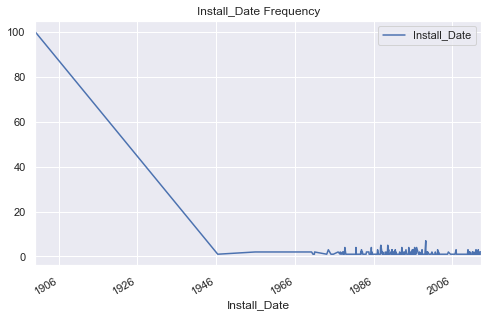

Install_Date data type:  datetime64[ns]


In [37]:
# Apply the convertdates function to the Install Date column
#devicedf['Install_Date'] = 
devicedf['Install_Date'] = devicedf[['Install_Date', 'Install_Date_New_Format']].apply(DSPCleanse.convertdates, axis=1)
# Convert the INSTALL_DATE column to datetime64
devicedf['Install_Date'] = devicedf['Install_Date'].astype('datetime64[ns]')
# Exmine Results
devicedf.groupby('Install_Date').agg({'Install_Date':'count'}).plot(kind='line', title='Install_Date Frequency')
plt.show()
print("Install_Date data type: ", devicedf['Install_Date'].dtypes)

The above confirms that the Install_Date column has been completely converted to datetime64, it also shows a number ofvalues that were previously NULL at 01/01/1900; these values were imputed later from events post joining.

#### Cleanse Phases
The following steps were carried out to cleanse the Phases column:
* Use the fillna function to replace missing values with THREE as this is the most comon value.
* Use the replace function to replace THREE with 3 and SINGLE with 1.
* Convert the column to the int datatype.

The below plot shows the new values.

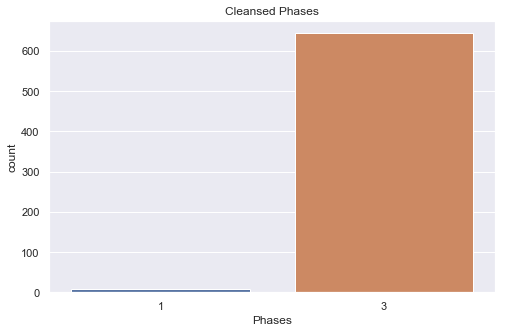

NULL Values: 0


In [38]:
# Replace NULLs with THREE in Phases 
devicedf['Phases'].fillna("THREE", inplace=True)
# Create a dictionary to map THREE to 3 and SINGLE to 1
phasedict = {"THREE":3,"SINGLE":1}
# Replace the required values based on the dictionary
devicedf['Phases'] = devicedf['Phases'].astype(str).replace(phasedict).astype(int)
# Check Values
ax = sns.countplot(x="Phases", data=devicedf).set_title('Cleansed Phases')
plt.show()
print("NULL Values:" ,devicedf['Phases'].isnull().sum())

#### Cleanse Power_Mva
As identified in the data exploration section; some values have been reported in the wrong unit of measure, they are a factor of one thousand higher than the other values. Therefore a function was defined; reduceby1000 in the DSPCleanse library. The function will divide the input value by 1000 if the value is greater than 1000, i.e. 7500 becomes 7.5.
Also as identified previously, the Spanish decimal and thousands seperator format is in use. The cleansedecimals function is used to replace a comma with a point after points are first removed, this function can be found in the DSPCleanse library.

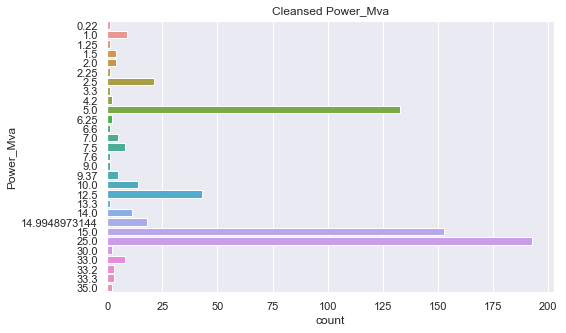

In [39]:
# Power_Mva column
# Replace the commas and points by passing the column to the cleansedecimals function
devicedf['Power_Mva'] = devicedf['Power_Mva'].astype(str).apply(DSPCleanse.cleansedecimals)
devicedf['Power_Mva'] = devicedf['Power_Mva'].astype(float).apply(DSPCleanse.reduceby1000)
devicedf['Power_Mva'].fillna((devicedf['Power_Mva'].mean()), inplace=True)
# check unique values
ax = sns.countplot(y="Power_Mva", data=devicedf).set_title('Cleansed Power_Mva')
plt.show()

#### Cleanse Voltage Regulation
The following steps were carried out to cleanse the Voltage Regulation column:
* Use the fillna function to replace missing values with NO as YES represents True and the absence of a value False.
* Use the replace function to replace YES with 1 and NO with 0.
* Convert the column to the boolean datatype.

The below plot shows the new values.

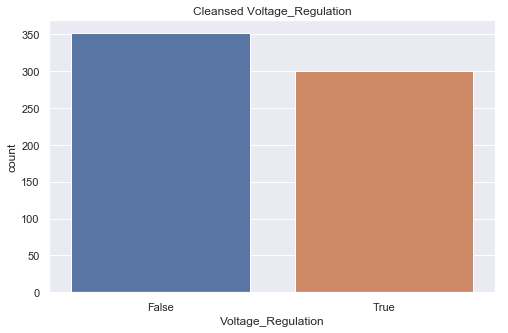

In [40]:
## Cleanse Voltage Regulation
# Replace NULLs with NO
devicedf['Voltage_Regulation'].fillna("NO", inplace=True)
# Replace YES with 1 and NO with 0
Voltagedict = {"YES":"1","NO":"0"}
devicedf['Voltage_Regulation'] = devicedf['Voltage_Regulation'].astype(str).replace(Voltagedict)
# Convert to boolean
devicedf['Voltage_Regulation'] = devicedf['Voltage_Regulation'].astype(int).astype(bool)
# check unique values
ax = sns.countplot(x="Voltage_Regulation", data=devicedf).set_title('Cleansed Voltage_Regulation')
plt.show()

#### Cleanse Nominal_Voltage_Kv
The Spanish decimal and thousands seperator format is in use for the Nominal_Voltage_Kv column. The cleansedecimals function was again used to replace a comma with a point after points are first removed. NULL values were replaced with the mean value for the column.

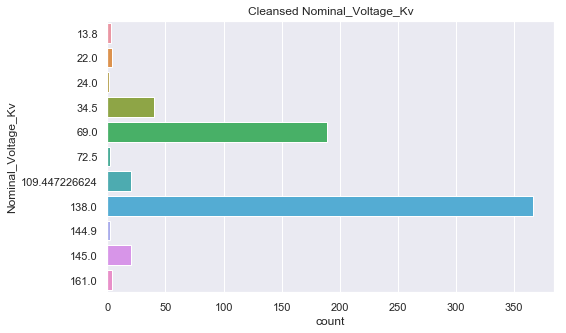

In [41]:
# Nominal_Voltage_Kv
# Replace the commas and points by passing the column to the cleansedecimals function
devicedf['Nominal_Voltage_Kv'] = devicedf['Nominal_Voltage_Kv'].astype(str).apply(DSPCleanse.cleansedecimals)
devicedf['Nominal_Voltage_Kv'] = devicedf['Nominal_Voltage_Kv'].astype(float)
devicedf['Nominal_Voltage_Kv'].fillna((devicedf['Nominal_Voltage_Kv'].mean()), inplace=True)
# check unique values
ax = sns.countplot(y="Nominal_Voltage_Kv", data=devicedf).set_title('Cleansed Nominal_Voltage_Kv')
plt.show()

The Install_Date_Format and Install_Date_New_Format columns were used to aid cleansing so they were dropped. The DSPAnalyse.dataprofile function was applied to the processed device data to confirm the data meets the required format, results below show the processing steps were sucessful.

In [42]:
# Drop the columns used for cleansing only
devicedf = devicedf.drop(['Install_Date_Format', 'Install_Date_New_Format'], axis=1)
# Re-profile the data post cleansing
display(DSPAnalyse.dataprofile(devicedf).style.set_table_styles(dfstyles).set_caption('Processed Devices Table - Data Profile'))

,Column,Data Type,Max Length,Max Length Value,Min Length,Min Length Value,Null #,Null %,Row Count,Unique Values
0,Id,object,32,e230c8f5b9c635e054be4463878b1f37,32,e230c8f5b9c635e054be4463878b1f37,0,0,651,651
1,Type,object,38,Transformer (Mobile SS remote control),17,Power Transformer,0,0,651,4
2,Area,object,2,NT,2,NT,0,0,651,7
3,Function,object,9,MOBILE SS,2,T3,0,0,651,15
4,Manufacturer,object,11,MAN-UNKNOWN,6,MAN-22,0,0,651,22
5,Install_Date,datetime64[ns],10,2012-06-15 00:00:00,10,2012-06-15 00:00:00,0,0,651,418
6,Phases,int32,1,3,1,3,0,0,651,2
7,Power_Mva,float64,13,14.9949,3,5,0,0,651,29
8,Voltage_Regulation,bool,5,False,4,True,0,0,651,2
9,Nominal_Voltage_Kv,float64,13,109.447,4,69,0,0,651,11


## Descriptive Analysis and further processing

### Join Data
Once the two data tables had been cleansed the next step was to join them together. Joining datasets is often called enriching as this is where the value can be derived. Missing dates in the devices table can be imputed from the events as well as further analysis and aggregation steps applied. The dataframes were joined using "left join" with the devices table as the left table and events the right. This join type was chosen because devices with no events need to be retained, as they never failed, and events without devices are useless for investigating the method in question. This was done by using the merge function on Equipment_Id.

In [43]:
# Left join events to devices
devicedf['Equipment_Id'] = devicedf['Id']
df = pd.merge(devicedf, eventdf, on='Equipment_Id', how='left')

In [44]:

display(df[df['Op_Id'].isnull()].groupby('Equipment_Id').agg({'Equipment_Id':'count'}).style.set_table_styles(dfstyles)\
        .set_caption('Devices without Events'))

,Equipment_Id
Equipment_Id,
0c74226bdaf49504f9c17db776b16222,1
3461287177268f4149acd9cf71adcca7,1
38c57fe7a56b0b056bae57d3c44de6fc,1
487b3c368b1c6746c617e98a1584659f,1
6f8d430e629794458d668be7ab343626,1
71ca86ba75298ba0ec8221f74320a64a,1
727b1b09beeff18d7bef6eebb01e4e7e,1
79f0432640394260fe80c39f57f50c4e,1
a3f250faa49196fced0fc9d83cdaf566,1


Devices with missing events required some imputation. In order to minimise NULL values, missing Op_dates were filled with the Max Op_date for the dataset. A device without an event infers it has not failed, so the fail flag was set to false for these devices.

In [45]:
# Devices without events
# For devices with missing events fill the Op_date with the Max Op_date in the dataset
df['Op_Date'].fillna(df['Op_Date'].max(), inplace=True)
# Any device without an event has not failed so the fail flag should be set to false
df['Fail_Flag'] = df['Fail_Flag'].fillna(False)

#### Missing install dates
Missing install dates (01/01/1900) were imputed as follows:
* Create a new dataframe grouped by device.
* Calculate the date difference between the Minimum and Maximum Op_Date for each device. 
* Drop any device from the joined dataset where the device only has events within a 3 year period and the device has failed, this is because it is impossible to tell if the device operated without issue for a number of years before its first event.
* Join the data together and update the remaining, missing install dates with the minimum Op_Date per device.

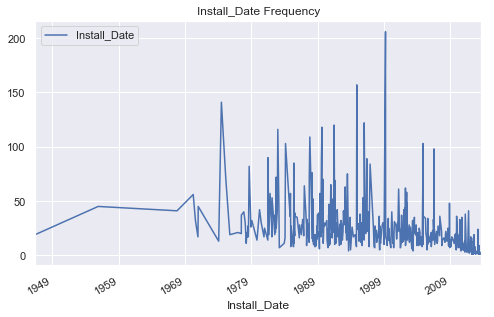

In [46]:
# For devices where the install date is missing (01/01/1900) calculate the date difference between Min/Max Op_Dates \
# for the device and remove if less than three years
dffixdates = df[df['Install_Date'] == '1900-01-01'].groupby('Equipment_Id').agg({'Op_Date':['min','max'],'Fail_Flag':['max']})
# Remove the multiindex from the dataframe
dffixdates.columns = [col[0] + "_" + col[1] for col in dffixdates.columns]
# Get the date difference between the minimum and maximum Op_date for each device 
dffixdates['MinMax_Date_Diff'] = (dffixdates['Op_Date_max'] - dffixdates['Op_Date_min']).dt.days
# Get a list of devices that only have events within a 3 year period and have failed
Equipmenttodrop = list(dffixdates[(dffixdates['MinMax_Date_Diff'] < 1095) & (dffixdates['Fail_Flag_max'] == True)].index)
# Drop these rows from the dataframe
df = df[~df['Equipment_Id'].isin(Equipmenttodrop)]
# Prepare for joining
dffixdates['Equipment_Id'] = dffixdates.index
# Subset the df
dffixdates = dffixdates[['Equipment_Id','Op_Date_min']]
dffixdates.columns = ['Equipment_Id','New_Install_Date']
# Left join to the main df 
df = pd.merge(df, dffixdates, on='Equipment_Id', how='left')
# Update the missing install dates remaining with the minimum Op_Date for the device
df.loc[df.Install_Date == '1900-01-01', 'Install_Date'] = df['New_Install_Date']
# Exmine Results
df.groupby('Install_Date').agg({'Install_Date':'count'}).plot(kind='line', title='Install_Date Frequency')
plt.show()

The above plot confirms that the "1900" dates have been replaced sucessfully.

#### Multiple Critical Failures

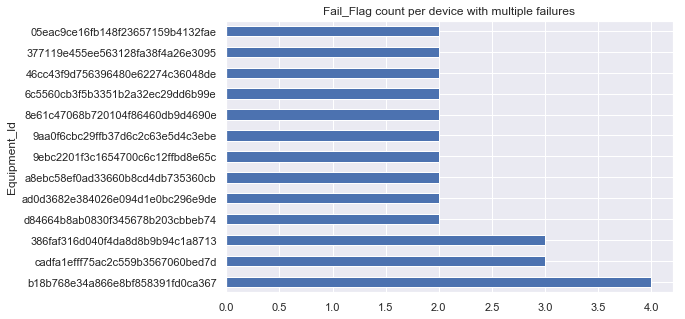

In [47]:
MultipleFails = df[df['Fail_Flag'] == True].groupby('Equipment_Id').filter(lambda x: len(x) > 1).groupby('Equipment_Id').size().\
sort_values(ascending=False)
MultipleFails.plot(kind='barh',title= "Fail_Flag count per device with multiple failures")
plt.show()

Some devices, shown above, had more than one critical failure, which is impossible as failure is distructive. The first failure was retained and later rows dropped. The process was as follows:
* Select all the rows where the Fail_Flag is set to true.
* Group by device and find the minimum Op_Date.
* Append this Failure Date to the main dataframe.
* Remove any record where the Op_Date is after critical failure.

After this process, two devices remained, but as the duplicate flags were set on the same Op_Date, aggregation removed these later in the process.

In [48]:
# Remove events after critical failures
# For devices where there is a critical failure calculate the Min Op_Date at failure  
dffixff = df[df['Fail_Flag'] == True].groupby('Equipment_Id').agg({'Op_Date':['min','max']})
# Remove the multiindex from the dataframe
dffixff.columns = [col[1] for col in dffixff.columns]
# Prepare for joining
dffixff['Equipment_Id'] = dffixff.index
# Subset the df
dffixff = dffixff[['Equipment_Id','min']]
dffixff.columns = ['Equipment_Id','Fail_Date']
# Left join to the main df 
df = pd.merge(df, dffixff, on='Equipment_Id', how='left')
# Drop any record where an event occurs after failure
df = df.drop(df[(df['Fail_Date'] < df['Op_Date'])].index, axis=0)

### Aggregation
The aim of this investigation is to examine the factors associated with the early life or wear and tear failure of a device it makes sense to aggregate the data to device level and summarise the observations accordingly.
For each device the following information was derived in the table below:

In [49]:
# Create a grouped dataframe per device with features available for further analysis
df2 = df.groupby('Equipment_Id').agg({'Op_Date':['min','max'], 'Install_Date':['first'],'Manufacturer':['first'],\
                                     'Area_Code':['first'],'Fail_Flag':['max'],'Type':['first'],'Area':['first'],\
                                     'Function':['first'],'Phases':['first'],'Power_Mva':['first'],\
                                      'Voltage_Regulation':['first'],'Nominal_Voltage_Kv':['first'], 'Fail_Date':['first'], \
                                      'Op_Id':['count']})
# Drop the multi-index
df2.columns = [col[0] + "_" + col[1] for col in df2.columns]
# Clean the columns
df2.columns = [column.replace("_first","").replace("Fail_Flag_max","Fail_Flag").replace("Op_Id_count","Event_Count") \
               for column in df2.columns]
display(df2.head(5).style.set_table_styles(dfstyles).set_caption('Aggregated dataframe - Top 5 rows'))

,Op_Date_min,Op_Date_max,Install_Date,Manufacturer,Area_Code,Fail_Flag,Type,Area,Function,Phases,Power_Mva,Voltage_Regulation,Nominal_Voltage_Kv,Fail_Date,Event_Count
Equipment_Id,,,,,,,,,,,,,,,
008852f51589a06679d79a2d95c33e3d,2002-04-12 00:00:00,2002-04-12 00:00:00,2002-04-01 00:00:00,MAN-23,TA,True,Power Transformer,TA,T3,3,25,True,138,2002-04-12 00:00:00,1
0115fdf279c8026f21a8e4e53a6b2635,2003-05-07 00:00:00,2013-07-30 00:00:00,1996-01-12 00:00:00,MAN-04,MQ,False,Regulator Power Autotransformer,MQ,T2,3,33.2,True,138,NaT,49
015542827dd6cf53a5163211cb1619cc,2004-09-06 00:00:00,2013-06-06 00:00:00,2004-09-06 00:00:00,MAN-01,OE,False,Power Transformer,OE,T3,3,1,False,34.5,NaT,12
01c9ee9c15cd6d0fc930684d5ec1686a,2004-11-30 00:00:00,2013-06-06 00:00:00,1997-08-17 00:00:00,MAN-23,OE,False,Power autotransformer,OE,T1,3,15,False,138,NaT,8
027d5dbe35e803d04b553e323826de49,2005-05-02 00:00:00,2013-05-22 00:00:00,1978-09-06 00:00:00,MAN-23,CE,False,Power Transformer,CE,T3,3,25,False,138,NaT,14


#### Devices with differing Area and Area_Code

In [50]:
# Devices with differing Area and Area_Code
diffareadf = df2[['Area_Code','Area']][df2['Area_Code'] != df2['Area']].reset_index()
display(diffareadf.style.set_table_styles(dfstyles).set_caption('Devices with differing Area and Area_Code'))

,Equipment_Id,Area_Code,Area
0,031023abc02ab8a117cdc73628d0063f,LE,OE
1,0b349064c57807ae6c8d7e17a6847519,CE,OE
2,0c74226bdaf49504f9c17db776b16222,nan,MQ
3,3461287177268f4149acd9cf71adcca7,nan,NT
4,38c57fe7a56b0b056bae57d3c44de6fc,nan,CE
5,487b3c368b1c6746c617e98a1584659f,nan,CE
6,6f8d430e629794458d668be7ab343626,nan,CE
7,71ca86ba75298ba0ec8221f74320a64a,nan,LE
8,727b1b09beeff18d7bef6eebb01e4e7e,nan,CE
9,73f670cd3659d5d8c28b5f1eb349ce7d,CE,LE


After aggregation, further inconsistancies were discovered. The above table shows devices where the Area_Code and Area columns are not equal, the column in the Device table was dropped and the Area column from Events retained as this is the location of failure.

#### Devices with Install Data after Failure Date

In [51]:
# Drop the Area_Code column
df2 = df2.drop('Area_Code',axis=1)

In [52]:
# Identify records where the install date is after the failure date
display(df2[df2['Fail_Date'] < df2['Install_Date']].style.set_table_styles(dfstyles).set_caption('Devices with Install Data after Failure Date'))

,Op_Date_min,Op_Date_max,Install_Date,Manufacturer,Fail_Flag,Type,Area,Function,Phases,Power_Mva,Voltage_Regulation,Nominal_Voltage_Kv,Fail_Date,Event_Count
Equipment_Id,,,,,,,,,,,,,,
6c5560cb3f5b3351b2a32ec29dd6b99e,2000-11-22 00:00:00,2003-08-07 00:00:00,2007-06-07 00:00:00,MAN-08,True,Regulator Power Autotransformer,CE,T1,3,25,True,138,2003-08-07 00:00:00,12
ad0d3682e384026e094d1e0bc296e9de,2000-07-25 00:00:00,2009-01-30 00:00:00,2012-02-09 00:00:00,MAN-UNKNOWN,True,Power Transformer,TA,T1,3,5,False,69,2009-01-30 00:00:00,7
e833855283e009d5bd952c6472d6c9fd,2002-09-23 00:00:00,2008-04-02 00:00:00,2008-11-21 00:00:00,MAN-23,True,Power Transformer,TA,T1,3,25,True,138,2008-04-02 00:00:00,25


Another inconsistancy discovered was Install Date values was after failure.
One device was removed, as it was the only one where the difference between the minimum and maximum Op_Date is less than 3 years, meaning it could have failed within three years, or it may have been running for several years without an issue. Other devices have event dates spanning a period greater than three years; and are therefore classed as wear-and-tear failures. Install dates were set to the minimum Op_Date for the remaining devices.

In [53]:
# Drop device 6c5560cb3f5b3351b2a32ec29dd6b99e because the difference between min and max Op_Date is less than 3 years
df2 = df2.drop(df2[df2.index == '6c5560cb3f5b3351b2a32ec29dd6b99e'].index, axis=0)
# Update the incorrect install dates remaining with the minimum Op_Date for the device
df2.loc[df2.index.isin(['ad0d3682e384026e094d1e0bc296e9de', 'e833855283e009d5bd952c6472d6c9fd']), 'Install_Date'] \
= df2['Op_Date_min'] 

#### Categorise Early Life Failure
It is useful to categorise each device in relation to Early Life Failure. The date difference between Install_Date and failure date for each device was obtained. Any device with a Time to Fail of less than 1095 days is an Early Life Failure, any other device either failed due to wear-and-tear or did not fail at all.

In [54]:
# Identify Early Life Failures
# Get the date difference between the Install_Date and the failure date for each device 
df2['Time_To_Fail'] = (df2['Fail_Date'] - df2['Install_Date']).dt.days
df2['Time_To_Fail'] = df2['Time_To_Fail'].fillna(41000)
# ELF is defined by a time to fail of 1095 days or less
df2['ELF'] = df2['Time_To_Fail'] < 1096
df2['ELF'] = df2['ELF'].fillna(False)

#### Time Based Features
Further time based features were added in case they could be of any value, these include:
* Install_Year - to see if a device manufactured at a certain point in time is more prone to failure.
* Fail_Month - to examine whether seasonal variation is a predictor of failure.
* Fail_Year - to examine whether a particular year had more or less failures than any others.

In [55]:
# Derive additional time based features
df2['Install_Year'] = df2['Install_Date'].dt.year
df2['Fail_Month'] = df2['Fail_Date'].dt.month
df2['Fail_Year'] = df2['Fail_Date'].dt.year

#### Categorical KDE Plot
At this point it was appropriate to investigate the categorical variables in relation to the time to failure. A for loop was employed to plot each categorical varable as a Kernel density estimation plot, each category was then plot as a seperate legend item with a further loop.  
The KDE plot is, in simple terms, a smoothed histogram. KDE plots are more useful than histograms when plotting continueous variables, as histograms use bins and are inherently discrete.

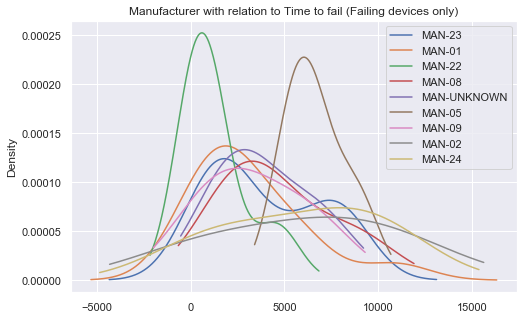

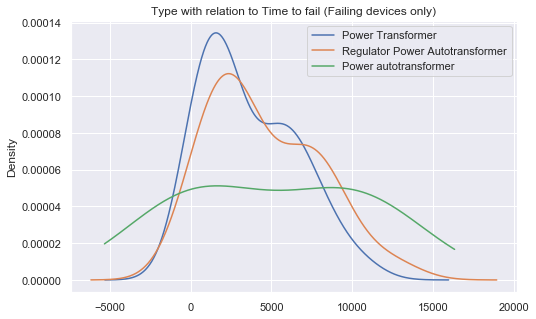

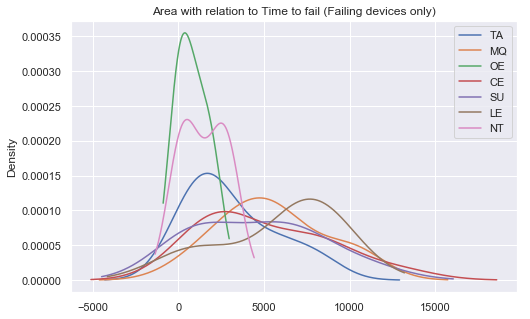

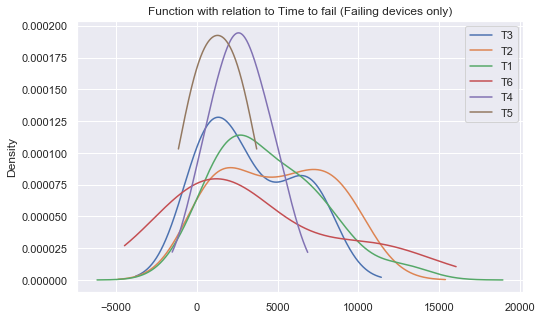

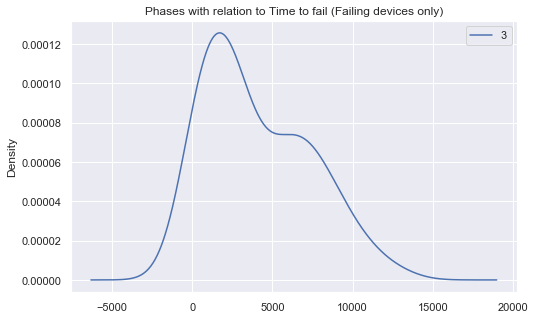

In [56]:
# Categorical variables vs time to fail
catlist = ['Manufacturer', 'Type', 'Area', 'Function', 'Phases']
#catlist = ['Function']
for c in catlist:
    legendlist = []
    for a in df2[c].unique(): 
        try: 
            df2.Time_To_Fail[(df2[c] == a) & (df2['Fail_Flag'] == True)].plot(kind="kde", \
            title=c + " with relation to Time to fail (Failing devices only)")
            legendlist.append(a)
        except:
            continue
    plt.legend(legendlist)
    plt.show()

One can see from the above plots that Manufacturer 22 has a large amount of early failures and Manufacturer 5 tends to fail later. In relation to Area, TA, OE and NT have more early failures and LE has more wear and tear failures. Devices with a T5 function tend to fail earlier than devices with other functions.
The Phases column was dropped at this point, because there are no devices failing that have a Single phase, this is perhaps because they are fewer in number and have lower power ratings.

In [57]:
# Drop the Phases column
df2 = df2.drop('Phases',axis=1)


### Prepare for Modelling

#### Dummy Variables
In order to fit a model against the data; dummy variables required to be assigned to categorical variables. This process involves seperating each category out into its own column and assigning a True/False (1/0) value. If the values were kept in the same column, but converted to a numerical value, the machine learning model would interpret each value as having some kind of increase or decrease with relation to other values.  

In [58]:
# Create dummy varibles from the categorical observations
catlist = ['Manufacturer', 'Type', 'Area', 'Function']
dummylist = catlist
df3 = pd.get_dummies(data=df2, columns=dummylist)

#### Rescaling
To improve the efficacy of the model, any observation containing continuous data required rescaling. Rescaling reduces dimensionality and avoids a situation where some attributes overweigh others. In this case, the MinMaxScaler() from sklearn.preprocessing was used on each of the continuous variables. Numerical values are transformed to ranges, e.g. from 0.0 to 1.0 where 0.0 represents the minimum values and 1.0 the maximum. 

In [59]:
# Min Max scaling
df4 = df3
scalelist = ['Power_Mva', 'Voltage_Regulation','Nominal_Voltage_Kv','Event_Count', 'Install_Year']
scaler = MinMaxScaler()
df4[scalelist] = scaler.fit_transform(df3[scalelist])

## Modelling

Before modelling, the data needed splitting into training and test sets.
The sklearn.model_selection library includes a function for this purpose, train_test_split was passed the independant and target columns, a test size of 0.3 was selected, meaning 30% of the data would be retained for testing.

In [60]:
# Independent columns
X = df4[['Power_Mva', 'Voltage_Regulation', 'Nominal_Voltage_Kv', 'Install_Year',
       'Manufacturer_MAN-01', 'Manufacturer_MAN-02', 'Manufacturer_MAN-03', 'Manufacturer_MAN-04',
       'Manufacturer_MAN-05', 'Manufacturer_MAN-07', 'Manufacturer_MAN-08',
       'Manufacturer_MAN-09', 'Manufacturer_MAN-10', 'Manufacturer_MAN-11',
       'Manufacturer_MAN-12', 'Manufacturer_MAN-13', 'Manufacturer_MAN-14',
       'Manufacturer_MAN-19', 'Manufacturer_MAN-21', 'Manufacturer_MAN-22',
       'Manufacturer_MAN-23', 'Manufacturer_MAN-24', 'Manufacturer_MAN-25',
       'Manufacturer_MAN-26', 'Manufacturer_MAN-27',
       'Manufacturer_MAN-UNKNOWN', 'Type_Power Transformer',
       'Type_Power autotransformer', 'Type_Regulator Power Autotransformer',
       'Type_Transformer (Mobile SS remote control)', 'Area_CE', 'Area_LE',
       'Area_MQ', 'Area_NT', 'Area_OE', 'Area_SU', 'Area_TA',
       'Function_MOBILE SS', 'Function_RESERVE', 'Function_T1', 'Function_T11',
       'Function_T13', 'Function_T14', 'Function_T2', 'Function_T25',
       'Function_T3', 'Function_T4', 'Function_T5', 'Function_T6',
       'Function_T7', 'Function_T8', 'Function_T9']] 
# Target column
y = df4['Time_To_Fail'].astype(int)
# Split Data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print("Training Shape: X =", X_train.shape, "y =", y_train.shape)
print("Testing Shape: X =", X_test.shape, "y =",y_test.shape)

Training Shape: X = (455, 52) y = (455,)
Testing Shape: X = (195, 52) y = (195,)


The model chosen was ExtraTreesClassifier from the sklearn library. The model works by fitting a number of randomized decision trees on different samples of the dataset, then uses averaging to improve the accuracy and reduce over-fitting. A decision tree splits data into smaller and smaller groups, until there are data points under just one label. Some of the benefits of this type of model are:
* Quick Training and prediction Speed
* Parallelizable
* Great with High dimensionality

The model was fit on the training data then passed the test data to form a prediction.

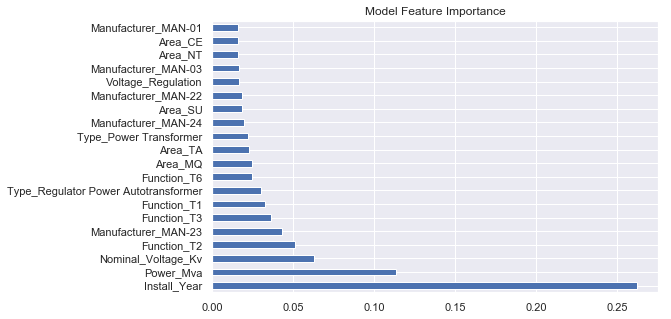

In [61]:
model = ExtraTreesClassifier()
#model = RandomForestClassifier()
model.fit(X_train,y_train)
preds = model.predict(X_test)
# plot feature importance
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances.nlargest(20).plot(kind='barh', title="Model Feature Importance")
plt.show()

Once the model has been fit to the data; Feature Importance can be examined. Feature Importance, quite simply, highlights the attributes that contribute most to predicting the target variable. One can see from the above plot that Install Year, Power and function are important, and to a lesser extent Manufacturer and Area. 

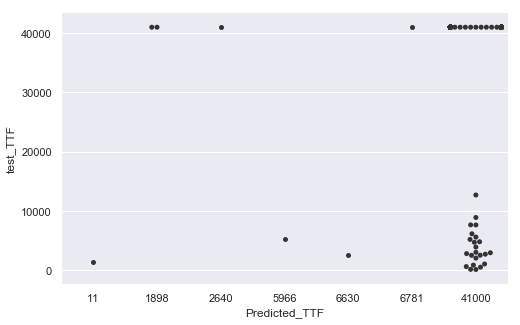

Accuracy Score: 0.846153846154


In [62]:
preddf = pd.DataFrame({"test_TTF":y_test, "Predicted_TTF":preds})
ax = sns.swarmplot(y = preddf['test_TTF'], x= preddf["Predicted_TTF"],color=".2").set_title=("Predicted vs Actual Time To Fail")
plt.show()
print("Accuracy Score:", accuracy_score(y_test, preds))

Accuracy Score =  $\frac{TP+TN}{TP+TN+FP+FN}$

Where:
* TP = True Positive
* FP = False Positive
* TN = True Negative
* FN = False Negative

One can infer from the above plot that the model is better at predicting wear and tear failures than early life failures. The model could be further optomised by trying different arguements and perhaps chosing some different models for comparison. 

## Conclusions and Recommendations
The feature importance of the model highlighted which parameters could be investigated further. These are discussed below.

#### Power and Nominal Voltage

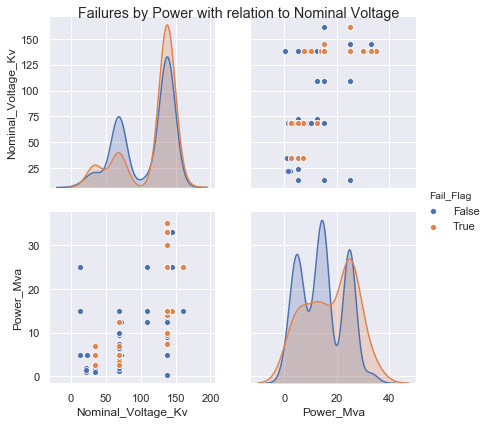

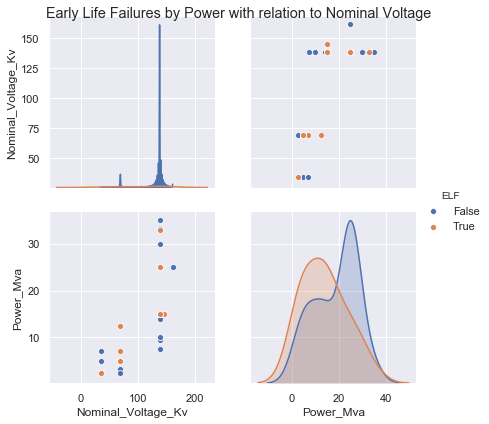

In [63]:
g = sns.pairplot(df2, hue="Fail_Flag",vars=["Nominal_Voltage_Kv", "Power_Mva"],height=3)
g.fig.suptitle('Failures by Power with relation to Nominal Voltage')
plt.show()
g = sns.pairplot(df2[df2['Fail_Flag'] == True], hue="ELF",vars=["Nominal_Voltage_Kv", "Power_Mva"],height=3)
g.fig.suptitle('Early Life Failures by Power with relation to Nominal Voltage')
plt.show()

Nominal Voltage and Power are obviously linked, since for a three phase device MVA = $\frac{(V*I*1.732)}{100,000}$
Once can see from the above pair plots of Voltage and Power, that devices with high voltage and power ratings have more failures. However it is the lower power devices that are more prone to early life failure.

#### Install Date and Power

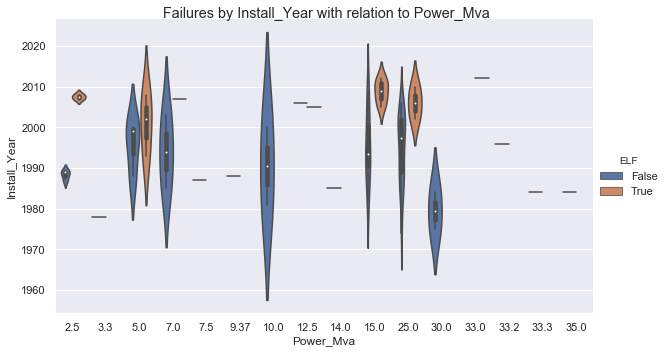

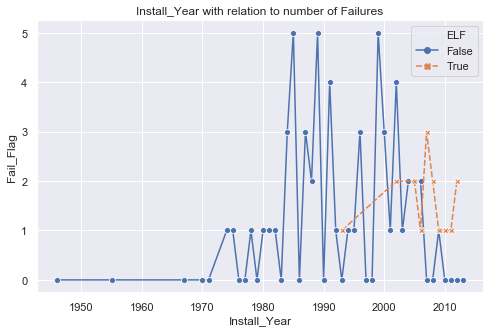

In [64]:
g = sns.catplot(y="Install_Year", x="Power_Mva", hue="ELF", data=df2[df2['Fail_Flag'] == True],height=5, aspect=1.7, \
                kind='violin')
g.fig.suptitle('Failures by Install_Year with relation to Power_Mva')
plt.show()
dfyf = df2.groupby(['Install_Year', 'ELF']).agg({'Fail_Flag':'sum'})
dfyf = dfyf.reset_index()
ax = sns.lineplot(x="Install_Year", y="Fail_Flag", hue = "ELF", style = "ELF", markers=True ,data=dfyf)\
.set_title('Install_Year with relation to number of Failures')
plt.show()

Install Year came out as the most important feature of the model. In the plot above, Install Year is compared with power. Devices rated at 7, 10 and 30 MVA have very little early life failures, but a number of wear and tear failures. Both plots above show that devices installed more recently, tend to have more early life failures.

#### Function and Power

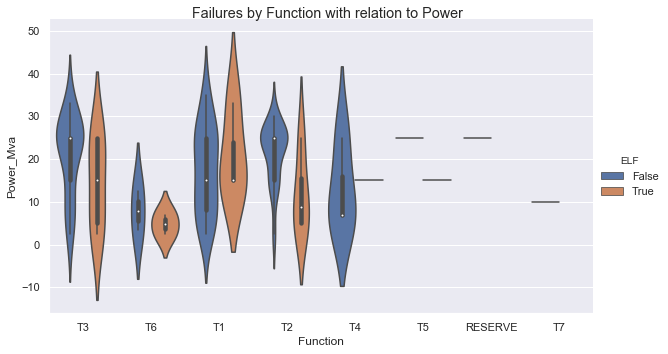

In [65]:
g = sns.catplot(x="Function", y="Power_Mva", hue="ELF", data=df2[df2['Fail_Flag'] == True],height=5, aspect=1.7, kind='violin')
g.fig.suptitle('Failures by Function with relation to Power')
plt.show()

The above plot show that devices with a T4 function are not very susceptible to early life failure, but they do have a number of wear and tear failures usually on low Power rated devices.

#### Manufacturer

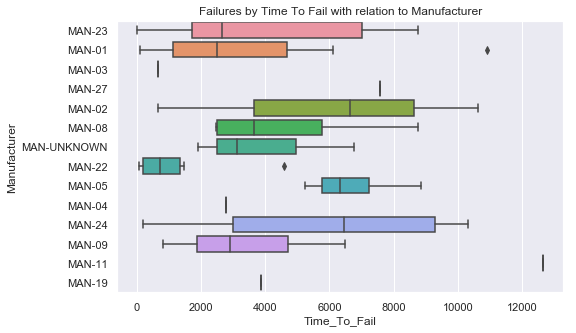

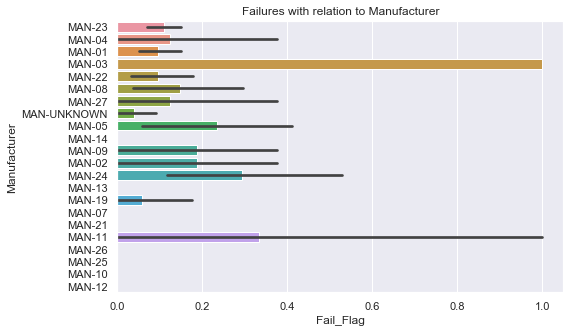

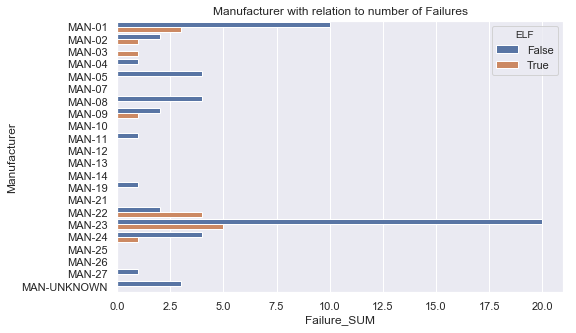

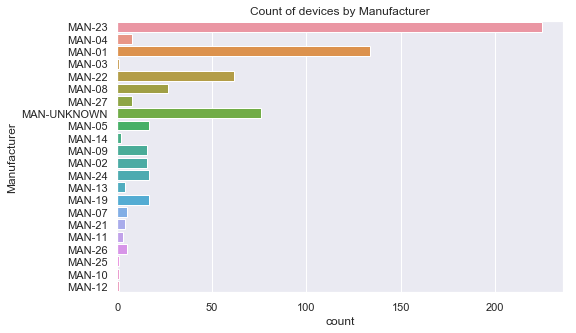

In [66]:
ax = sns.boxplot(y="Manufacturer", x="Time_To_Fail", data=df2[df2['Fail_Flag'] == True])\
.set_title('Failures by Time To Fail with relation to Manufacturer')
plt.show()
ax = sns.barplot(x="Fail_Flag", y="Manufacturer", data=df2)\
.set_title('Failures with relation to Manufacturer')
plt.show()
dfman = df2.groupby(['Manufacturer', 'ELF']).agg({'Fail_Flag':'sum'})
dfman = dfman.reset_index()
dfman.columns = ["Manufacturer", "ELF", "Failure_SUM"]
ax = sns.barplot(y="Manufacturer", x="Failure_SUM", hue = "ELF" ,data=dfman)\
.set_title('Manufacturer with relation to number of Failures')
plt.show()
ax = sns.countplot(y="Manufacturer", data=df2).set_title('Count of devices by Manufacturer')
plt.show()

As shown above; Manufacturer 3 failed 100% of the time and this was an Early Life Failure, perhaps the power company decided not to use the manufacturer after this event. Manufacturers 1 and 23 had the highest number of failures but a low mean fail_flag, meaning they are the most reliable manufacturers overall. Manufacturers 11, followed by 24 then 5 had the worst failure rates per device. Manufacturers 24 and 2 had the largest portion of wear and tear failures with a wide distribution of Time To Fail. A Number of Manufacturers had 0 Early Life failures. 

#### Failure Month

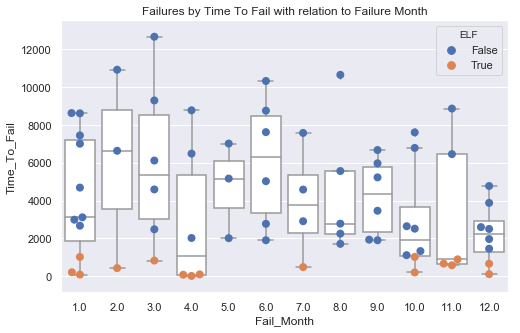

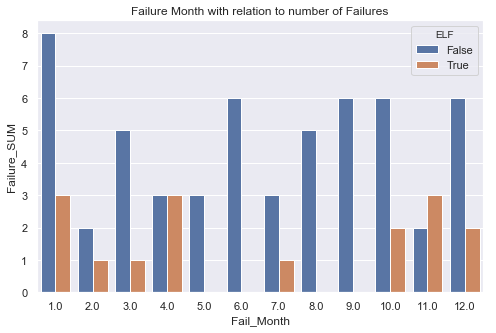

In [67]:
ax = sns.boxplot(x="Fail_Month", y="Time_To_Fail", data=df2[df2['Fail_Flag'] == True], color=(1, 1, 1, 0))\
.set_title('Failures by Time To Fail with relation to Failure Month')
ax = sns.swarmplot(x = df2['Fail_Month'][df2['Fail_Flag'] == True], y= df2['Time_To_Fail'][df2['Fail_Flag'] == True]\
                   , hue = df2['ELF'], edgecolor="black", size = 8)
plt.show()

dfmth = df2.groupby(['Fail_Month', 'ELF']).agg({'Fail_Flag':'sum'})
dfmth = dfmth.reset_index()
dfmth.columns = ["Fail_Month", "ELF", "Failure_SUM"]
ax = sns.barplot(x="Fail_Month", y="Failure_SUM", hue = "ELF" ,data=dfmth)\
.set_title('Failure Month with relation to number of Failures')
plt.show()

Fail Month was not included in the model; because the value was NULL for non-failures, and there was not an acceptable fill value. Analysis of the above, infers there is definate seasonality with relation to Early Life Failure. In the warmer months; October to April there is a considerable amount of Early Life failures; with the exception of one Early Life Failure in July, there are no Early Life Failures between May and October.

#### Area

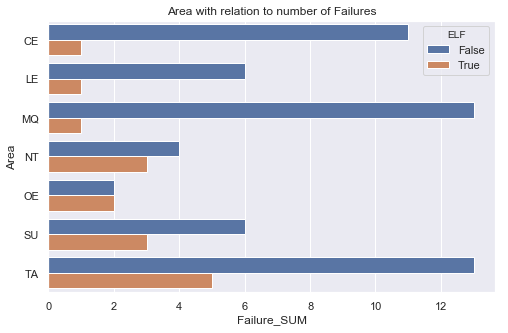

In [68]:
dfarea = df2.groupby(['Area', 'ELF']).agg({'Fail_Flag':'sum'})
dfarea = dfarea.reset_index()
dfarea.columns = ["Area", "ELF", "Failure_SUM"]
ax = sns.barplot(y="Area", x="Failure_SUM", hue = "ELF" ,data=dfarea)\
.set_title('Area with relation to number of Failures')
plt.show()

The above plot shows that the MQ area has the highest number of failures, followed by TA then CE, the proportion of Early life failures is much higher in the TA area. OE and NT have a more equal proportion of Early life and Wear-and-tear failures. 

### Recommendations
Based on the conclusions contained within this report, one would recommend the following actions.

In relation to Wear and Tear Failures; maintenance effort should be concentrated on devices from Manufacturers 24 and 2, as they had the largest proportion of this mode of failure. Devices with a Power rating of 7, 10 and 30 MVA had the highest number of Wear-and-tear failures, these devices should be investigated further to determine the root cause. Engineering resource should be focussed on the MQ area.

Regarding Early life failures; the warmer months of the year have a much higher rate of this type of failure, and this should be investigated. Perhaps there a common issue at installation due to weather conditions in the summer months. Devices installed more recently have a higher number of early life failures; perhaps the quality of devices being manufactured has deteriorated. 

## References
* Pandas: Comparison with SQL: https://pandas.pydata.org/pandas-docs/stable/getting_started/comparison/comparison_with_sql.html
* Data Visualization using Seaborn: https://towardsdatascience.com/data-visualization-using-seaborn-fc24db95a850
* Dummy Coding: The how and why: https://www.statisticssolutions.com/dummy-coding-the-how-and-why/
* Seaborn: API reference: https://seaborn.pydata.org/api.html
* Preparing Your Dataset for Machine Learning: 8 Basic Techniques That Make Your Data Better: https://www.statisticssolutions.com/dummy-coding-the-how-and-why/
* ExtraTreesClassifier: https://medium.com/@namanbhandari/extratreesclassifier-8e7fc0502c7
* Why Random Forest is My Favorite Machine Learning Model: https://towardsdatascience.com/why-random-forest-is-my-favorite-machine-learning-model-b97651fa3706
* Calculation of KVA or MVA capacity of single phase and three phase transformer: https://eblogbd.com/calculation-kva-mva-capacity-single-phase-three-phase-transformer/